<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/chest_xray_cgan_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Chest X-ray Augmentation using cGAN (Colab-ready)
This notebook trains a Conditional GAN (cGAN) to augment a medical image dataset (Chest X-rays: Normal vs Pneumonia). It then evaluates the effect of augmentation using a CNN classifier.

In [1]:
# 📦 Install and Import Dependencies
!pip install torchvision matplotlib --quiet
import torch, os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.8 MB/s eta 0:00:00


In [27]:
# 1. Upload your kaggle.json API token file first:
from google.colab import files
files.upload()  # Upload kaggle.json here

# 2. Setup Kaggle API and download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# 3. Unzip the dataset
!unzip -q chest-xray-pneumonia.zip -d chest_xray_data

# 4. Load dataset with PyTorch
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset_path = 'chest_xray_data/chest_xray/train'
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Loaded {len(dataset)} images from {len(dataset.classes)} classes: {dataset.classes}")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:24<00:00, 63.6MB/s]
100% 2.29G/2.29G [00:24<00:00, 99.5MB/s]
Loaded 5216 images from 2 classes: ['NORMAL', 'PNEUMONIA']


In [28]:
# 🧠 Define cGAN Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, z_dim, label_dim, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, img_dim),
            nn.Tanh()
        )
    def forward(self, z, labels):
        x = torch.cat([z, labels], 1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = torch.cat([x, labels], 1)
        return self.model(x)

In [30]:
# 🔁 Train the cGAN
z_dim = 100
img_dim = 64*64
num_classes = len(dataset.classes)
G = Generator(z_dim, num_classes, img_dim).to(device)
D = Discriminator(img_dim, num_classes).to(device)
opt_g = torch.optim.Adam(G.parameters(), lr=0.0002)
opt_d = torch.optim.Adam(D.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

for epoch in range(10):  # Reduce epochs for Colab demo
    for real, labels in dataloader:
        real = real.view(-1, img_dim).to(device)
        labels = nn.functional.one_hot(labels, num_classes).float().to(device)
        z = torch.randn(real.size(0), z_dim).to(device)
        fake = G(z, labels)
        D_real = D(real, labels)
        D_fake = D(fake.detach(), labels)
        D_loss = loss_fn(D_real, torch.ones_like(D_real)) + loss_fn(D_fake, torch.zeros_like(D_fake))
        opt_d.zero_grad(); D_loss.backward(); opt_d.step()
        D_fake = D(fake, labels)
        G_loss = loss_fn(D_fake, torch.ones_like(D_fake))
        opt_g.zero_grad(); G_loss.backward(); opt_g.step()
    print(f"Epoch {epoch+1}: D Loss = {D_loss.item():.4f}, G Loss = {G_loss.item():.4f}")

Epoch 1: D Loss = 0.5181, G Loss = 1.3506
Epoch 2: D Loss = 0.5536, G Loss = 2.2766
Epoch 3: D Loss = 0.2721, G Loss = 2.9559
Epoch 4: D Loss = 0.0599, G Loss = 3.7724
Epoch 5: D Loss = 0.0889, G Loss = 3.2957
Epoch 6: D Loss = 0.0587, G Loss = 3.3927
Epoch 7: D Loss = 0.0941, G Loss = 2.8244
Epoch 8: D Loss = 0.3691, G Loss = 1.7343
Epoch 9: D Loss = 0.6584, G Loss = 1.0858
Epoch 10: D Loss = 0.6010, G Loss = 1.1106


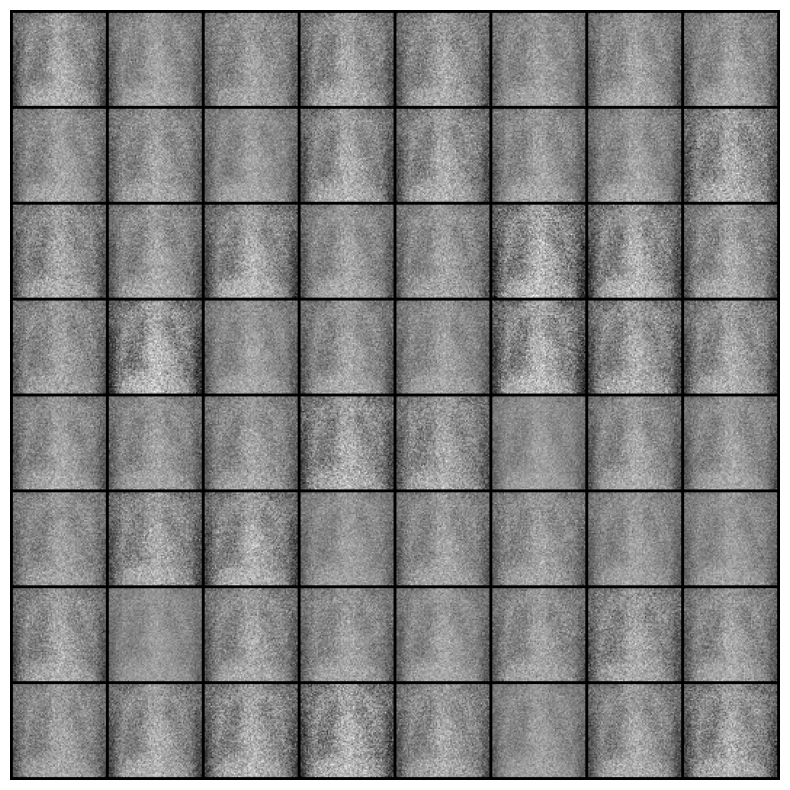

In [31]:
# 🎨 Visualize Generated Images
def show_images(fake_imgs):
    imgs = fake_imgs.view(-1, 1, 64, 64)
    grid = make_grid(imgs, nrow=8, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.show()

z = torch.randn(64, z_dim).to(device)
labels = torch.eye(num_classes)[torch.randint(0, num_classes, (64,))].to(device)
fake_imgs = G(z, labels)
show_images(fake_imgs)

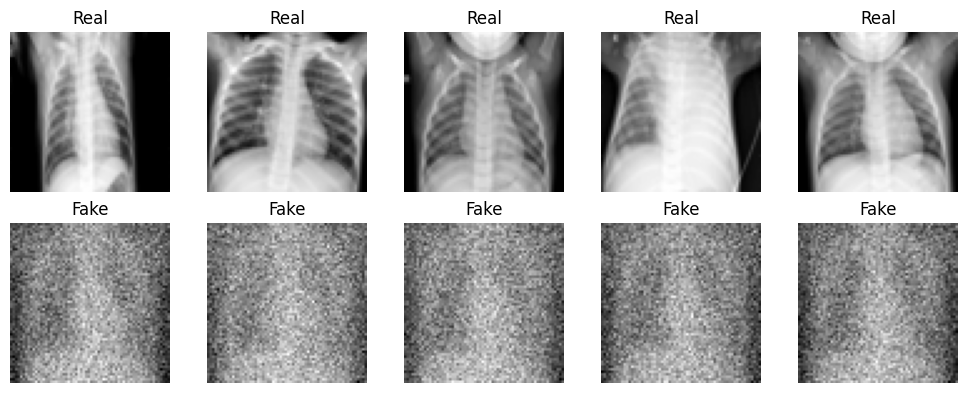

In [32]:
import matplotlib.pyplot as plt

def show_real_vs_fake(real_imgs, fake_imgs, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Real image
        plt.subplot(2, n, i+1)
        plt.imshow(real_imgs[i].squeeze().cpu().numpy(), cmap='gray')
        plt.title("Real")
        plt.axis('off')

        # Fake image
        plt.subplot(2, n, i+1+n)
        plt.imshow(fake_imgs[i].view(64, 64).detach().cpu().numpy(), cmap='gray')
        plt.title("Fake")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch from dataloader
real_batch, labels = next(iter(dataloader))
real_imgs = real_batch[:5].to(device)
labels = labels[:5]
z = torch.randn(5, z_dim).to(device)
labels_onehot = nn.functional.one_hot(labels, num_classes).float().to(device)
fake_imgs = G(z, labels_onehot)

show_real_vs_fake(real_imgs, fake_imgs)


In [33]:
import torch.nn.functional as F

# Compute pixel-wise L1 loss (Mean Absolute Error)
l1_diff = F.l1_loss(fake_imgs, real_imgs.view(-1, img_dim)).item()
print(f"Average L1 difference: {l1_diff:.4f}")


Average L1 difference: 0.3554
